In [51]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import glob

In [70]:
### !!! VERY CONSUMING OPERATION !!! ###

# Path to the directory containing the CSV files
path = "TON_IOT_Datasets/Processed_Network_dataset/"

# Define the target number of rows
target_row_count = 5_000_000
rows_per_file = target_row_count // 23

# Use glob to get all file paths matching the pattern
all_files = glob.glob(path + "Network_dataset_*.csv")

# Initialize an empty list to store sampled DataFrames
sampled_dfs = []

# Loop through each file, read it in its entirety, and sample rows
for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    sampled_df = df.sample(n=min(len(df), rows_per_file), random_state=42)
    sampled_dfs.append(sampled_df)

# Concatenate all sampled DataFrames into one
combined_df = pd.concat(sampled_dfs, ignore_index=True)

# Adjust the sample size if combined_df has fewer rows than target_row_count
final_sample_size = min(len(combined_df), target_row_count)

# Randomly shuffle and limit rows to final_sample_size
final_df = combined_df.sample(n=final_sample_size, random_state=42).reset_index(drop=True)
df = final_df

df.head()

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type,uid
0,1556029027,192.168.1.31,53386,192.168.35.151,443,tcp,-,0.000000,0,0,...,0,-,-,-,-,-,-,1,scanning,NaN
1,1556027221,192.168.1.30,53241,192.168.1.180,63606,tcp,-,0.000000,0,0,...,0,-,-,-,-,-,-,1,scanning,NaN
2,1556238678,192.168.1.30,48844,192.168.1.184,80,tcp,http,0.006884,175,171,...,0,-,-,-,-,-,-,1,ddos,NaN
3,1556263694,192.168.1.38,41894,192.168.1.152,80,tcp,-,39.893225,0,0,...,0,-,-,-,-,-,-,1,ddos,NaN
4,1556133212,192.168.1.30,438,192.168.1.184,438,tcp,-,0.000001,0,0,...,0,-,-,-,-,-,-,1,dos,NaN


In [72]:
# Display the distribution of attack types in the final dataset
df['type'].value_counts()

type
scanning      1552228
ddos          1340172
dos            733790
xss            458530
password       373434
backdoor       239504
normal         187326
injection       98449
ransomware      15887
mitm              673
Name: count, dtype: int64

In [74]:
# Check for null values in the features
df.isnull().sum()

ts                              0
src_ip                          0
src_port                        0
dst_ip                          0
dst_port                        0
proto                           0
service                         0
duration                        0
src_bytes                       0
dst_bytes                       0
conn_state                      0
missed_bytes                    0
src_pkts                        0
src_ip_bytes                    0
dst_pkts                        0
dst_ip_bytes                    0
dns_query                       0
dns_qclass                      0
dns_qtype                       0
dns_rcode                       0
dns_AA                          0
dns_RD                          0
dns_RA                          0
dns_rejected                    0
ssl_version                     0
ssl_cipher                      0
ssl_resumed                     0
ssl_established                 0
ssl_subject                     0
ssl_issuer    

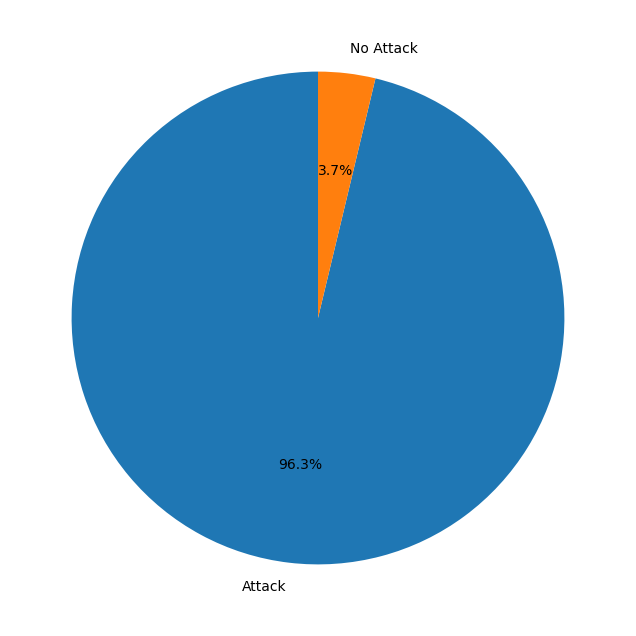

In [76]:
# Create pie chart which shows the percentage of attacks
attack_counts = df['label'].value_counts()
attack_counts.plot(kind='pie', 
                   labels=attack_counts.index.map({0: 'No Attack', 1: 'Attack'}), 
                   autopct='%1.1f%%', 
                   startangle=90, 
                   figsize=(8, 8))

# Show the plot
plt.ylabel('')  # Remove the y-axis label
plt.show()

In [78]:
# Show the distribution of attack types as a summary table
print(df['type'].value_counts())

type
scanning      1552228
ddos          1340172
dos            733790
xss            458530
password       373434
backdoor       239504
normal         187326
injection       98449
ransomware      15887
mitm              673
Name: count, dtype: int64


In [80]:
# Show the types of each column
df.dtypes

ts                          int64
src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                  object
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
ssl_subject                object
ssl_issuer    

In [88]:
label_encoder = LabelEncoder()
label_mappings = {}

# Apply label encoding to each non-numeric column and store mappings
for column in df.select_dtypes(include=['object']).columns:
    # Convert the column to string type to avoid mixed types
    df[column] = df[column].astype(str)
    
    df.loc[:, column] = label_encoder.fit_transform(df[column])
    
    # Store the mapping of label to encoded value for the column
    label_mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for column, mapping in label_mappings.items():
    print(f"{column}: {dict(list(mapping.items())[:5])}")

src_ip: {'0': 0, '1': 1, '10': 2, '100': 3, '1000': 4}
dst_ip: {'0': 0, '1': 1, '10': 2, '100': 3, '1000': 4}
proto: {'0': 0, '1': 1, '2': 2}
service: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4}
src_bytes: {'0': 0, '1': 1, '10': 2, '100': 3, '1000': 4}
conn_state: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4}
dns_query: {'0': 0, '1': 1, '10': 2, '100': 3, '1000': 4}
dns_AA: {'0': 0, '1': 1, '2': 2}
dns_RD: {'0': 0, '1': 1, '2': 2}
dns_RA: {'0': 0, '1': 1, '2': 2}
dns_rejected: {'0': 0, '1': 1, '2': 2}
ssl_version: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
ssl_cipher: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
ssl_resumed: {'0': 0, '1': 1, '2': 2}
ssl_established: {'0': 0, '1': 1, '2': 2}
ssl_subject: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
ssl_issuer: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
http_trans_depth: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
http_method: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
http_uri: {'0': 0, '1': 1, '10': 2, '100': 3, '101': 4}
http_referrer: {'0': 0, '1': 1}


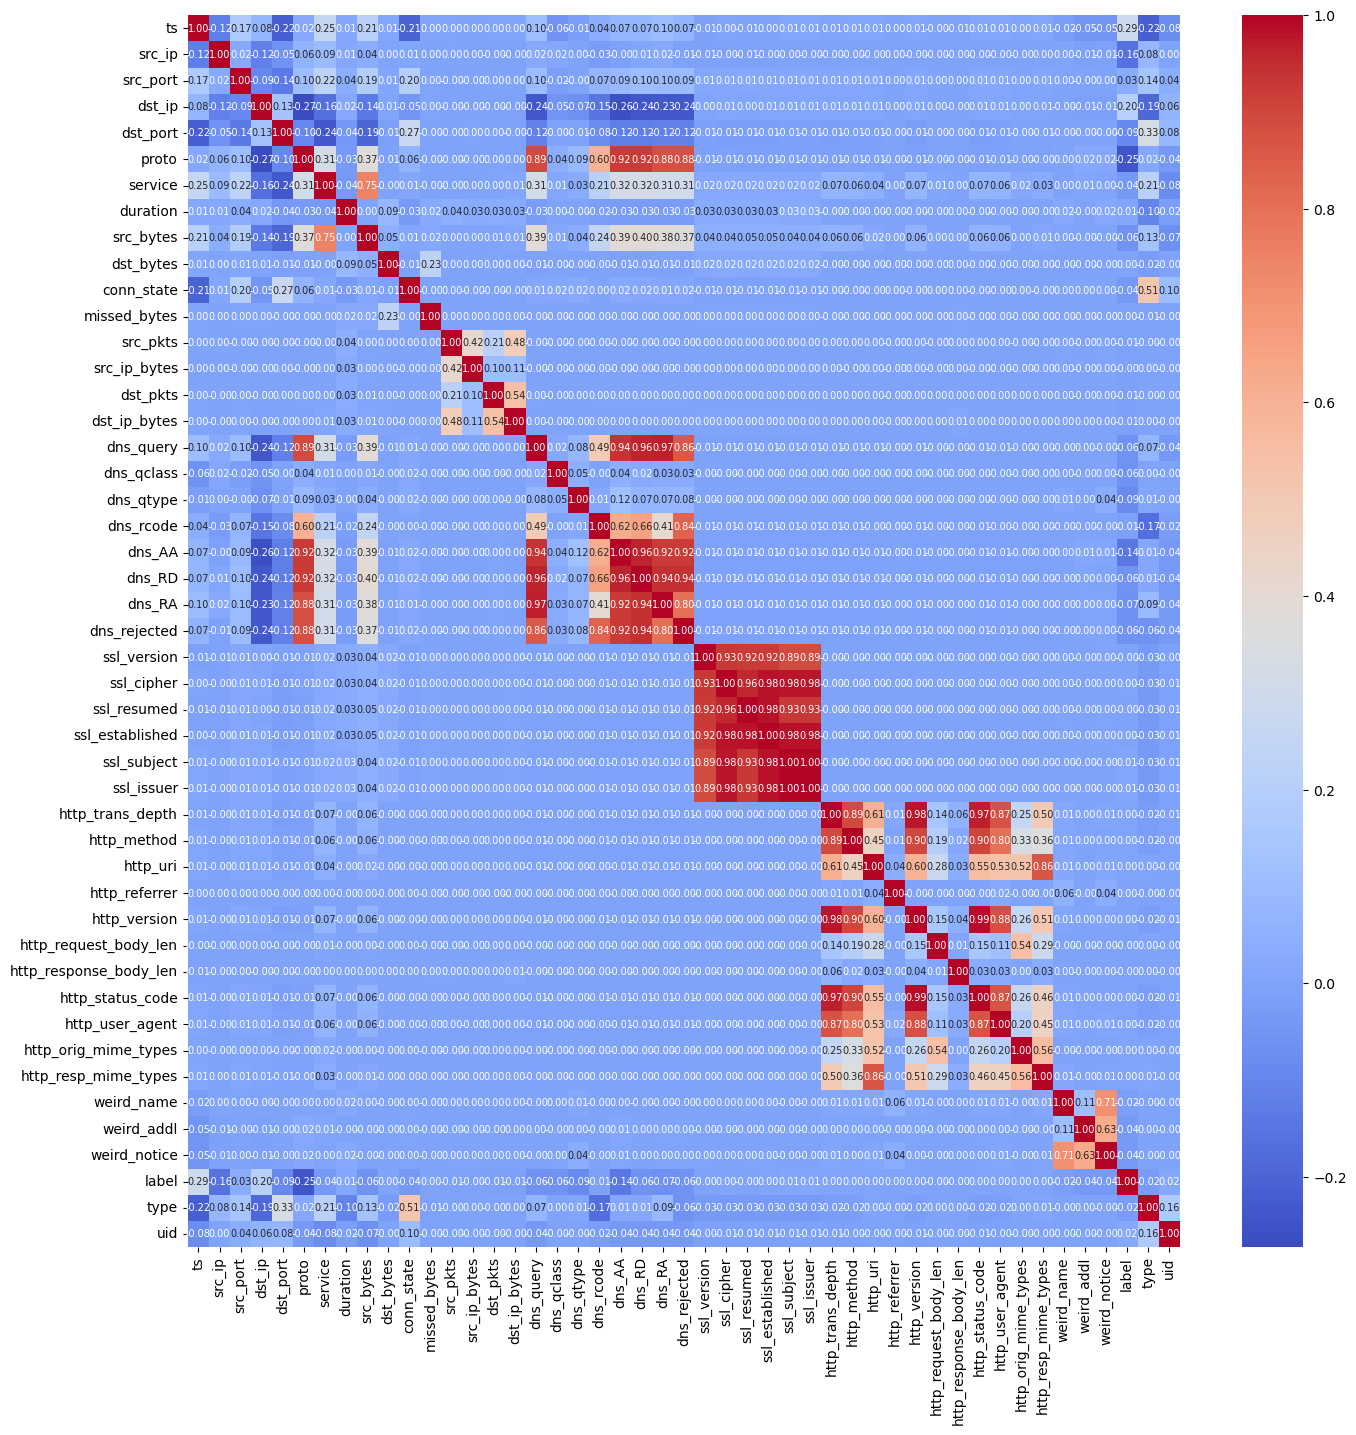

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove columns with only one unique value and create a copy
df = df.loc[:, df.nunique() > 1].copy()

# Calculate the correlation matrix
corr = df.corr()

# Visualize the correlation matrix with improved readability
plt.figure(figsize=(16, 16))  # Set a large figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 7})

# Show the plot
plt.show()

In [94]:
# Identify and drop highly correlated features
# Set a threshold for correlation
threshold = 0.95
to_drop = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            colname = corr.columns[i]
            to_drop.add(colname)

# Drop the correlated features
df = df.drop(columns=to_drop)

df.head()

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type,uid
0,1556029027,1480,53386,388,443,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,8,33820
1,1556027221,1469,53241,3672,63606,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,8,33820
2,1556238678,1469,48844,3685,80,1,21,0.006884,11977,171,...,0,0,0,0,0,0,0,1,1,33820
3,1556263694,1580,41894,3480,80,1,0,39.893225,0,0,...,0,0,0,0,0,0,0,1,1,33820
4,1556133212,1469,438,3685,438,1,0,0.000001,0,0,...,0,0,0,0,0,0,0,1,2,33820
